In [20]:
import os
import scipy.linalg as LA
import scipy.signal as ss
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


from weight import array_weight_vector
from utils import find_steering_matrix, nsb, capon, find_position_vector

repo_dir = os.getcwd()

## Sample Location Generation For Testing

In [2]:
np.random.seed(6)

P,Q = 8,8 # rows and columns of antenna array
lamda = 1 # wavelength
ue = 1  # number of user equipments
ris = 1  # number of RIS
n_source = ue+ris
n_antenna = P*Q  # number of antenna elements 
snr = 10

print('\nsimulation sample data\n----------------------')
array = np.linspace(0,(n_antenna-1)/2,n_antenna)

# angle for RIS would be added
p_thetas = (np.pi/3)*(np.random.rand(n_source))   # random source polar directions
az_thetas = (2*np.pi)*(np.random.rand(n_source))   # random source azimuthal directions

# p_thetas = input_signal.sample(1,random_state=21)[['polar1','polar2']].values[0]*np.pi/180
# az_thetas = input_signal.sample(1,random_state=21)[['azimuth1','azimuth2']].values[0]*np.pi/180

# power from RIS would be added
ue_alphas = np.sqrt(1/2)*(np.random.randn(ue) + np.random.randn(ue)*1j) # random UE powers
ris_alphas = np.sqrt(1/2)*(np.random.randn(ris) + np.random.randn(ris)*1j) # random RIS powers

print('random signal direction #polar:',p_thetas*180/np.pi)
print('random signal direction #azimuthal:',az_thetas*180/np.pi)

ue_vectors, ris_vectors = [],[]
ue_angles, ris_angles = [], []
for polar,az in zip(p_thetas[:ue],az_thetas[:ue]):
    ue_vectors.append(find_position_vector(polar,az))
    ue_angles.append([polar*180/np.pi,az*180/np.pi])

for polar,az in zip(p_thetas[ue:],az_thetas[ue:]):
    ris_vectors.append(find_position_vector(polar,az))
    ris_angles.append([polar*180/np.pi,az*180/np.pi])

bs_vector = [0,0,0]
print('\nbase station locations:',bs_vector)
print(f'\nRIS \ndirection vectors: {ris_vectors}\ndirection angles: {ris_angles}\npower: {ris_alphas}')
print(f'\nuser equipment \ndirection vectors: {ue_vectors}\ndirection angles: {ue_angles}\npower: {ue_alphas}')

# visualizing the simulation setup
coordinates = {
    'bs':[[0],[0],[0]],
    'ris':np.transpose(ris_vectors).tolist(),
    'ue':np.transpose(ue_vectors).tolist()
}


simulation sample data
----------------------
random signal direction #polar: [53.57160909 19.91878832]
random signal direction #azimuthal: [295.6424843   15.01078526]

base station locations: [0, 0, 0]

RIS 
direction vectors: [[0.006067509241204118, 2.7744162567926823e-05, 0.9999815921115096]]
direction angles: [[19.918788318070632, 15.010785261089966]]
power: [-1.75841946+0.64576634j]

user equipment 
direction vectors: [[0.016251992379168842, 0.0014675892375824373, 0.9998668505983872]]
direction angles: [[53.571609086160095, 295.64248430081943]]
power: [0.15402256-0.63575391j]


In [3]:
numAngles = 360
p_angles = np.linspace(0,np.pi/3,numAngles)*180/np.pi
az_angles = np.linspace(0,2*np.pi,numAngles)*180/np.pi
general_angles = np.array(np.meshgrid(p_angles,az_angles)).T.reshape(-1, 2).tolist()
print('Total sample location collected:', len(general_angles))

Total sample location collected: 129600


## Co-Variance Matrix

In [5]:
numrealization = 100 # number of time samples collected at antenna array
H = np.zeros((n_antenna,numrealization)) + 1j*np.zeros((n_antenna,numrealization))
print('H matrix shape(n_antenna,time_instance):',H.shape)
antenna_weight = array_weight_vector(ris_vectors,ue_vectors,ris_angles,ue_angles,vector=True,angle=True)

for iter in range(numrealization):
    #ris
    distortion_ris = np.exp(1j*2*np.pi*np.random.rand(1)) 
    recieved_power_ris = distortion_ris*ris_alphas*antenna_weight
    #ue
    distortion_ue = np.exp(1j*2*np.pi*np.random.rand(1))
    recieved_power_ue = distortion_ue*ue_alphas*antenna_weight
    
    net_recieved_power = recieved_power_ris+recieved_power_ue
    noise = np.sqrt(0.5/snr)*(np.random.randn(n_antenna)+np.random.randn(n_antenna)*1j)

    H[:,iter] = net_recieved_power+noise
CovMat = H@H.conj().transpose()
print('covariance matrix shape:',CovMat.shape)

H matrix shape(n_antenna,time_instance): (64, 100)
covariance matrix shape: (64, 64)


# With Deep Learning 

In [13]:
%%time

# MUSIC algorithm
# DoAsMUSIC, psindB = music(CovMat,
#                           n_source,
#                           n_antenna,
#                           angles=general_angles,
#                           ris_data=ris_angles+ris_vectors)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs


In [18]:
file_path = os.path.join(repo_dir,'data','psindB.pkl')
# with open(file_path, 'wb') as file:import scipy as ss
#     pkl.dump(psindB, file)
    
with open(file_path, 'rb') as file:
    psindB = pkl.load(file)

<IPython.core.display.Javascript object>


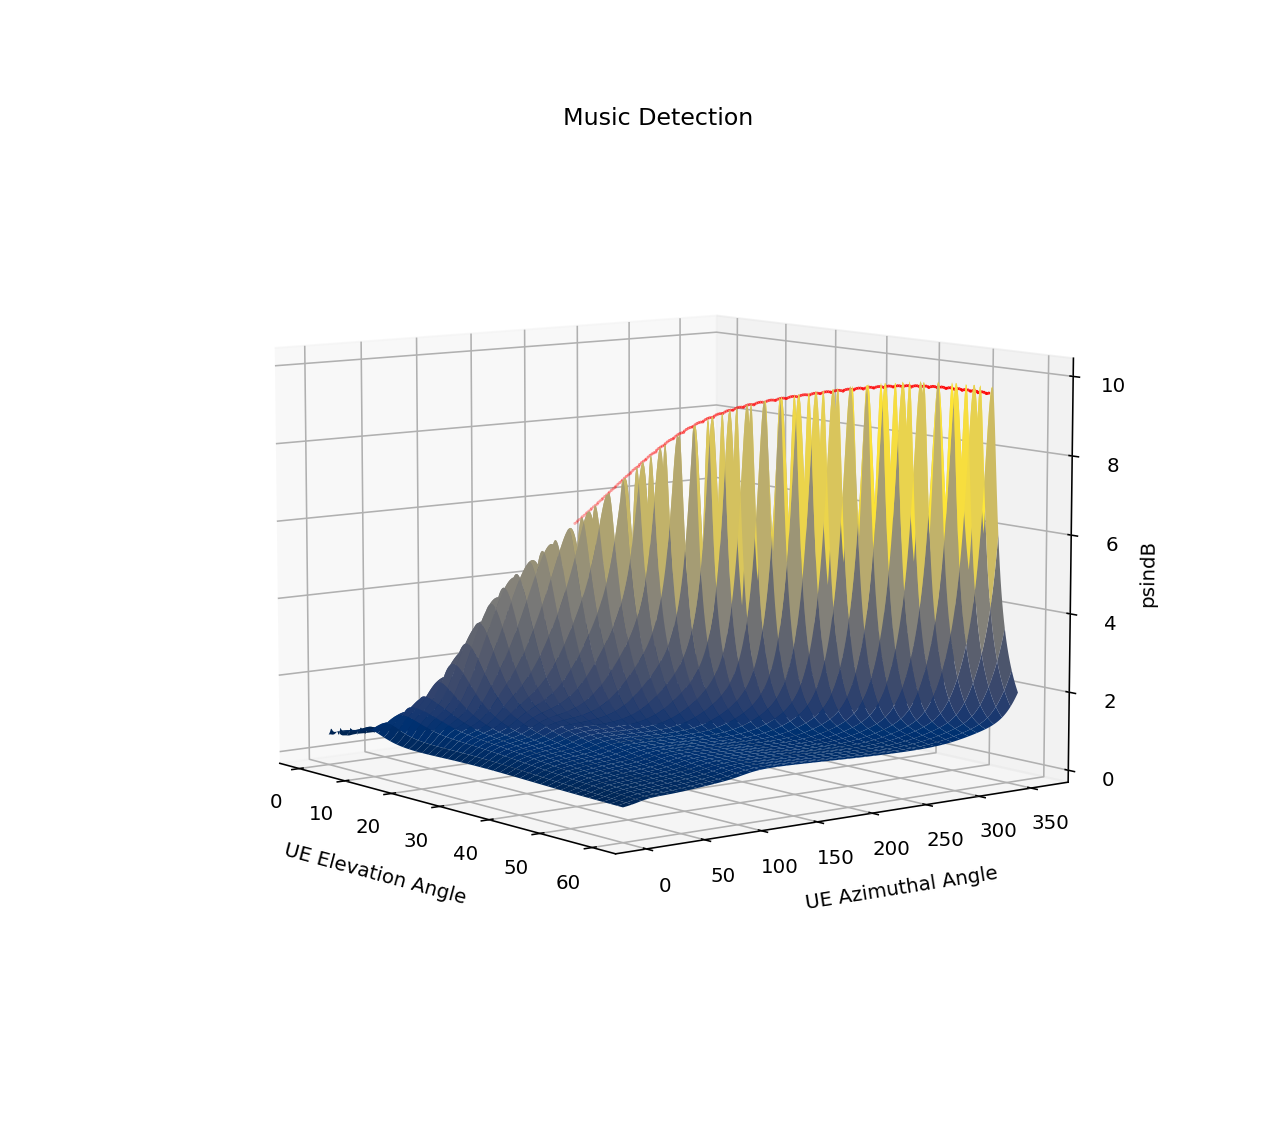

maximum psindB value: 9.771132545929415
peak reached at: [52.98050139275765, 295.8217270194986]
actual UE direction: [[53.571609086160095, 295.64248430081943]]


In [40]:
%matplotlib notebook
fig = plt.figure(figsize = (9,8))
ax = plt.axes(projection='3d')
# DoAsMUSIC,_= ss.find_peaks(psindB)
DoAsMUSIC,_ = ss.find_peaks(psindB, height=[6,11], distance=1.5)

X, Y = np.meshgrid(p_angles, az_angles)
Z = psindB[:129600].reshape(len(p_angles),len(p_angles))

surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

Xs = np.array(general_angles)[DoAsMUSIC][:,0]
Ys = np.array(general_angles)[DoAsMUSIC][:,1]
Zs = psindB[DoAsMUSIC]
ax.scatter(Xs,Ys,Zs,color='r',marker='.',s=1)

# Set axes label
ax.set_xlabel('UE Elevation Angle', labelpad=10)
ax.set_ylabel('UE Azimuthal Angle', labelpad=10)
ax.set_zlabel('psindB', labelpad=1)
ax.set_title("Music Detection")
print('maximum psindB value:',psindB[DoAsMUSIC].max())
print('peak reached at:',general_angles[DoAsMUSIC[np.argmax(psindB[DoAsMUSIC])]])
print('actual UE direction:',ue_angles)
# fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

## With NSB

In [10]:
# MUSIC algorithm
DoAsMUSIC, psindB = music(CovMat,
                          n_source,
                          n_antenna,
                          angles=general_angles,
                          ris_data=ris_angles+ris_vectors,
                          method='nsb')

Processing:   0%|          | 0/129600 [00:00<?, ?it/s]

Processing:   0%|          | 0/129600 [00:00<?, ?it/s]

/tmp/ipykernel_392930/1029862053.py:41: RuntimeWarning: divide by zero encountered in log10
  psindB = np.log10(10*pspectrum/(pspectrum.min()+1e-10))


In [11]:
file_path = os.path.join(repo_dir,'data','psindB-nsb.pkl')
# with open(file_path, 'wb') as file:
#     pkl.dump(psindB, file)
    
with open(file_path, 'rb') as file:
    psindB = pkl.load(file)

<IPython.core.display.Javascript object>


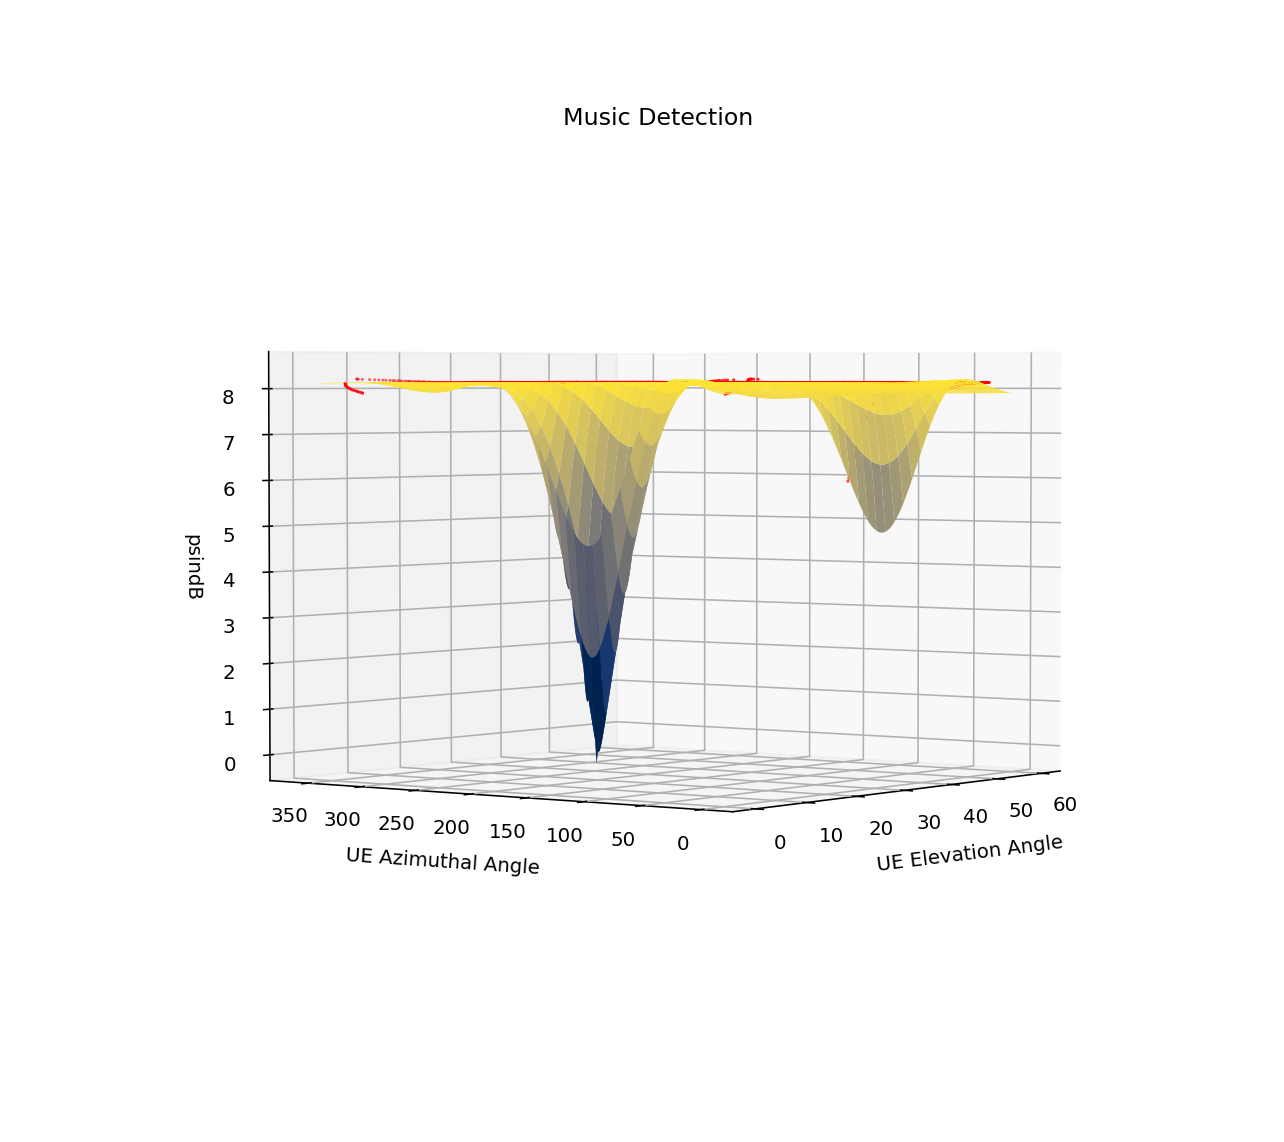

maximum psindB value: 8.210268764869634
peak reached at: [6.685236768802228, 6.016713091922004]
actual UE direction: [[53.571609086160095, 295.64248430081943]]


In [12]:
%matplotlib notebook
fig = plt.figure(figsize = (9,8))
ax = plt.axes(projection='3d')
# DoAsMUSIC,_= ss.find_peaks(psindB)
DoAsMUSIC,_ = ss.find_peaks(psindB, height=[6,11], distance=1.5)

X, Y = np.meshgrid(p_angles, az_angles)
Z = psindB[:129600].reshape(len(p_angles),len(p_angles))

surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

Xs = np.array(general_angles)[DoAsMUSIC][:,0]
Ys = np.array(general_angles)[DoAsMUSIC][:,1]
Zs = psindB[DoAsMUSIC]
ax.scatter(Xs,Ys,Zs,color='r',marker='.',s=1)

# Set axes label
ax.set_xlabel('UE Elevation Angle', labelpad=10)
ax.set_ylabel('UE Azimuthal Angle', labelpad=10)
ax.set_zlabel('psindB', labelpad=1)
ax.set_title("Music Detection")
print('maximum psindB value:',psindB[DoAsMUSIC].max())
print('peak reached at:',general_angles[DoAsMUSIC[np.argmax(psindB[DoAsMUSIC])]])
print('actual UE direction:',ue_angles)
# fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

## With Capon

In [76]:
ris_angles+ris_vectors

[[19.918788318070632, 15.010785261089966],
 [0.006067509241204118, 2.7744162567926823e-05, 0.9999815921115096]]

In [13]:
# MUSIC algorithm
DoAsMUSIC, psindB = music(CovMat,
                          n_source,
                          n_antenna,
                          angles=general_angles,
                          ris_data=ris_angles+ris_vectors,
                          method='capon')

Processing:   0%|          | 0/129600 [00:00<?, ?it/s]

Processing:   0%|          | 0/129600 [00:00<?, ?it/s]

/tmp/ipykernel_392930/1029862053.py:41: RuntimeWarning: divide by zero encountered in log10
  psindB = np.log10(10*pspectrum/(pspectrum.min()+1e-10))


In [18]:
# DoAsMUSIC
psindB

array([7.50365939, 7.50365939, 7.50365939, ..., 0.        , 0.        ,
       0.        ])

<IPython.core.display.Javascript object>


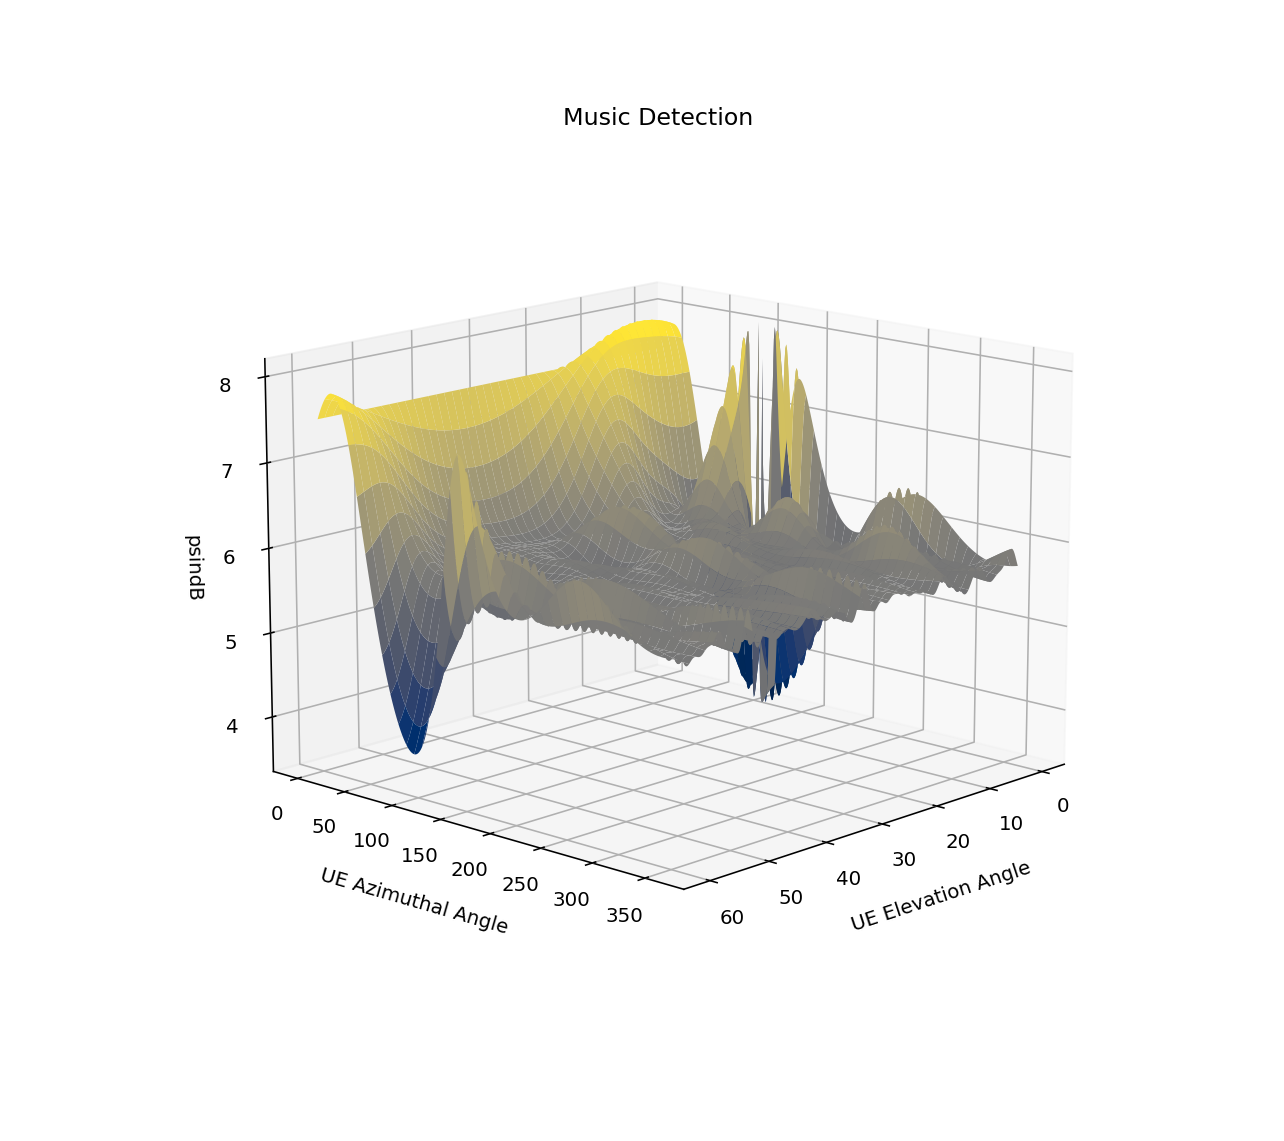

maximum psindB value: 8.110111096029778
peak reached at: [20.389972144846794, 13.036211699164344]
actual UE direction: [[53.571609086160095, 295.64248430081943]]


In [15]:
%matplotlib notebook
fig = plt.figure(figsize = (9,8))
ax = plt.axes(projection='3d')
# DoAsMUSIC,_= ss.find_peaks(psindB)
DoAsMUSIC,_ = ss.find_peaks(psindB, height=[6,11], distance=1.5)

X, Y = np.meshgrid(p_angles, az_angles)
Z = psindB[:129600].reshape(len(p_angles),len(p_angles))

surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

# Xs = np.array(general_angles)[DoAsMUSIC][:,0]
# Ys = np.array(general_angles)[DoAsMUSIC][:,1]
# Zs = psindB[DoAsMUSIC]
# ax.scatter(Xs,Ys,Zs,color='r',marker='.',s=1)

# Set axes label
ax.set_xlabel('UE Elevation Angle', labelpad=10)
ax.set_ylabel('UE Azimuthal Angle', labelpad=10)
ax.set_zlabel('psindB', labelpad=1)
ax.set_title("Music Detection")
print('maximum psindB value:',psindB[DoAsMUSIC].max())
print('peak reached at:',general_angles[DoAsMUSIC[np.argmax(psindB[DoAsMUSIC])]])
print('actual UE direction:',ue_angles)
# fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()